## Importing libraries

In [ ]:
# Removing warnings
import warnings
warnings.filterwarnings('ignore')

# Removing unwanted tensorflow logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import zipfile
import random
from shutil import copyfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
tf.__version__

%matplotlib inline

## Importing trianing data

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Accessing Covid19 Data from drive

In [ ]:
!pip install rarfile
import rarfile

In [ ]:
!ls "/content/gdrive/MyDrive/Colab Notebooks"

'Copy of Coding Tutorial.ipynb'
'Copy of Course 1 - Part 8 - Lesson 3 - Notebook.ipynb'
'Copy of Course 1 - Part 8 - Lesson 4 - Notebook.ipynb'
'Copy of Course 2 - Part 4 - Lesson 4 - Notebook.ipynb'
'Copy of Device placement.ipynb'
'Copy of Exercise_1_House_Prices_Question.ipynb'
'Copy of Exercise2-Question.ipynb'
'Copy of Exercise 4-Question.ipynb'
'Copy of Exercise 6 - Question.ipynb'
'Copy of Logs dictionary.ipynb'
'Copy of Week 1 Programming Assignment.ipynb'
'Copy of Week 2 Programming Assignment.ipynb'
'Copy of Week 3 Programming Assignment (1).ipynb'
'Copy of Week 3 Programming Assignment (2).ipynb'
'Copy of Week 3 Programming Assignment.ipynb'
 covid19_detection_using_tensorflow.ipynb
 COVID_19.ipynb
'COVID19 using pytorch chest x-rays.ipynb'
 COVID.rar
'India_vs_World_COVID_19 - Copy.ipynb'
 India_vs_World_COVID_19.ipynb
'Week 3 Coding Tutorial.ipynb'


In [ ]:
rar_ref = rarfile.RarFile("/content/gdrive/MyDrive/Colab Notebooks/COVID.rar")
rar_ref.extractall("/tmp/COVID19")
rar_ref.close()

In [ ]:
!ls "/tmp/COVID19/COVID"

test  train


#### Importing train data

In [ ]:
os.listdir('/tmp/COVID19/COVID/train')

['viral', 'normal', 'covid']

In [ ]:
training_covid_dir = "/tmp/COVID19/COVID/train/covid/"
training_normal_dir = "/tmp/COVID19/COVID/train/normal/"
training_viral_dir = "/tmp/COVID19/COVID/train/viral/"

print(len(os.listdir(training_covid_dir)))
print(len(os.listdir(training_normal_dir)))
print(len(os.listdir(training_viral_dir)))

189
200
200


#### Importing test data

In [ ]:
os.listdir('/tmp/COVID19/COVID/test')

['viral', 'normal', 'covid']

In [ ]:
testing_covid_dir = "/tmp/COVID19/COVID/test/covid/"
testing_normal_dir = "/tmp/COVID19/COVID/test/normal/"
testing_viral_dir = "/tmp/COVID19/COVID/test/viral/"

print(len(os.listdir(testing_covid_dir)))
print(len(os.listdir(testing_normal_dir)))
print(len(os.listdir(testing_viral_dir)))

30
30
30


## Rescaling train and test data according to compatible size for our model

Since we'll be using 2 different pretrained network both of them have different input sizes.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = '/tmp/COVID19/COVID/train'
test_dir = '/tmp/COVID19/COVID/test'

In [ ]:

BATCH_SIZE = 6 #10,16,32
LR = 3e-5
EPOCHS = 20
IMG_SIZE1 = 299
IMG_SIZE2 = 331
IMG_SIZE3 = 224

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range = 15,
                                   fill_mode = 'nearest',
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,batch_size=BATCH_SIZE,class_mode='categorical',target_size=(IMG_SIZE1,IMG_SIZE1))

validation_generator = test_datagen.flow_from_directory(test_dir,batch_size=BATCH_SIZE,class_mode='categorical',target_size=(IMG_SIZE1,IMG_SIZE1))

Found 589 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

## Defining model structure

### Transfer Learning setup

#### InceptionResNetV2

In [ ]:
# Necessary libraries

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

In [ ]:
def incepResNetV2():
  InceptionResNetV2_base_model = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299,299,3))
  # InceptionResNetV2_base_model.summary()
  #### LAST LAYER: conv_7b_ac (Activation)         (None, 8, 8, 1536)   0           conv_7b_bn[0][0]
  output = InceptionResNetV2_base_model.layers[-1].output
  output = Flatten()(output)
  
  model = Model(InceptionResNetV2_base_model.input,outputs=output)

  for layer in InceptionResNetV2_base_model.layers:
    layer.trainable = False

  return model

#### NASNetLarge

In [ ]:
from tensorflow.keras.applications import NASNetLarge

In [ ]:
def NASNetLarge_model():
  NASNetLarge_base_model = NASNetLarge(include_top=False, weights='imagenet',input_shape=(331, 331, 3))

  #### LAST LAYER Shape : (To be filled)

  output = NASNetLarge_base_model.layers[-1].output
  output = Flatten()(output)

  model = Model(NASNetLarge_base_model.input,outputs=output)

  for layer in NASNetLarge_base_model.layers:
    layer.trainable = False

  return model

#### Intergrating Transfer Learing model structure

In [ ]:
covid_model = Sequential()
covid_model.add(incepResNetV2())
covid_model.add(Dropout(0.3))
covid_model.add(Dense(512,activation='relu'))
covid_model.add(Dropout(0.3))
covid_model.add(Dense(64,activation='relu'))
covid_model.add(Dense(3,activation='softmax'))

covid_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 98304)             54336736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 98304)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               50332160  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 104,701,923
Trainable params: 50,365,187
Non-trainable params: 54,336,736
________________________________

## Model Training

In [ ]:
from tensorflow.keras.optimizers import Adam

OPTIMIZER = Adam(lr = LR)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4,mode='auto') # patience = 5

covid_model.compile(loss='categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy'])

history = covid_model.fit(train_generator,validation_data=validation_generator,epochs=EPOCHS,
                          callbacks=[callback])
                                    #steps_per_epoch=(589*0.75)//BATCH_SIZE,
                                    #validation_steps=(589*0.25)//BATCH_SIZE)
                            
covid_model.save_weights("/tmp/covid_model.h5")

Epoch 1/20
99/99 [==============================] - 28s 279ms/step - loss: 0.5663 - accuracy: 0.8081 - val_loss: 0.2062 - val_accuracy: 0.9444
Epoch 2/20
99/99 [==============================] - 25s 251ms/step - loss: 0.2248 - accuracy: 0.9202 - val_loss: 0.2450 - val_accuracy: 0.9444
Epoch 3/20
99/99 [==============================] - 25s 255ms/step - loss: 0.1916 - accuracy: 0.9372 - val_loss: 0.1883 - val_accuracy: 0.9556
Epoch 4/20
99/99 [==============================] - 25s 254ms/step - loss: 0.1484 - accuracy: 0.9440 - val_loss: 0.2045 - val_accuracy: 0.9333
Epoch 5/20
99/99 [==============================] - 25s 254ms/step - loss: 0.1587 - accuracy: 0.9338 - val_loss: 0.2130 - val_accuracy: 0.9444
Epoch 6/20
99/99 [==============================] - 25s 254ms/step - loss: 0.1328 - accuracy: 0.9559 - val_loss: 0.2346 - val_accuracy: 0.9333
Epoch 7/20
99/99 [==============================] - 25s 255ms/step - loss: 0.1120 - accuracy: 0.9508 - val_loss: 0.1741 - val_accuracy: 0.9556

In [ ]:
covid_model.save_weights("/tmp/covid_model.h5")

In [ ]:
!ls "/tmp/COVID19/COVID/test/viral/"

'Viral Pneumonia (1024).png'  'Viral Pneumonia (268).png'
'Viral Pneumonia (1079).png'  'Viral Pneumonia (369).png'
'Viral Pneumonia (1121).png'  'Viral Pneumonia (388).png'
'Viral Pneumonia (117).png'   'Viral Pneumonia (434).png'
'Viral Pneumonia (119).png'   'Viral Pneumonia (503).png'
'Viral Pneumonia (1220).png'  'Viral Pneumonia (521).png'
'Viral Pneumonia (1240).png'  'Viral Pneumonia (566).png'
'Viral Pneumonia (124).png'   'Viral Pneumonia (57).png'
'Viral Pneumonia (1253).png'  'Viral Pneumonia (686).png'
'Viral Pneumonia (1269).png'  'Viral Pneumonia (687).png'
'Viral Pneumonia (1288).png'  'Viral Pneumonia (918).png'
'Viral Pneumonia (1309).png'  'Viral Pneumonia (926).png'
'Viral Pneumonia (148).png'   'Viral Pneumonia (954).png'
'Viral Pneumonia (203).png'   'Viral Pneumonia (975).png'
'Viral Pneumonia (267).png'   'Viral Pneumonia (984).png'


In [ ]:
testing_covid_img = "/tmp/COVID19/COVID/test/viral/Viral Pneumonia (57).png"

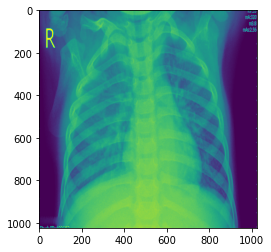

In [ ]:
img = plt.imread(testing_covid_img)
plt.imshow(img)

In [ ]:
img.shape

(1024, 1024)

In [ ]:
from tensorflow.keras.preprocessing import image
from PIL import Image

img_path = testing_covid_img
img = image.load_img(img_path, target_size=(IMG_SIZE1, IMG_SIZE1))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [ ]:
covid_model.predict(x)

array([[1., 0., 0.]], dtype=float32)

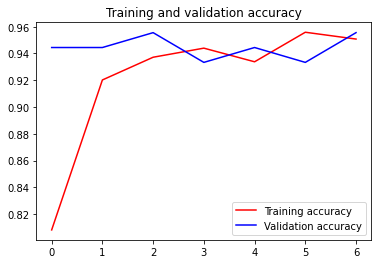

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

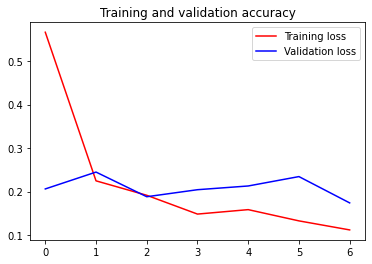

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
covid_model.evaluate(validation_generator, return_dict=True)

15/15 [==============================] - 2s 130ms/step - loss: 0.1741 - accuracy: 0.9556


{'accuracy': 0.9555555582046509, 'loss': 0.1741386353969574}

In [ ]:
covid_model1 = Sequential()
covid_model1.add(NASNetLarge_model())
covid_model1.add(Dropout(0.3))
covid_model1.add(Dense(512,activation='relu'))
covid_model1.add(Dropout(0.3))
covid_model1.add(Dense(64,activation='relu'))
covid_model1.add(Dense(3,activation='softmax'))

covid_model1.summary()

343613440/343610240 [==============================] - 6s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_5 (Functional)    (None, 487872)            84916818  
_________________________________________________________________
dropout_4 (Dropout)          (None, 487872)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               249790976 
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 334,740,821
Trainable params: 249,824,0

In [ ]:
train_generator1 = train_datagen.flow_from_directory(train_dir,batch_size=BATCH_SIZE,class_mode='categorical',target_size=(IMG_SIZE2,IMG_SIZE2))

validation_generator1 = test_datagen.flow_from_directory(test_dir,batch_size=BATCH_SIZE,class_mode='categorical',target_size=(IMG_SIZE2,IMG_SIZE2))

Found 589 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam


covid_model1.compile(loss='categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy'])

history1 = covid_model1.fit(train_generator1,validation_data=validation_generator1,epochs=EPOCHS,callbacks=[callback])

Epoch 1/20
99/99 [==============================] - 38s 386ms/step - loss: 1.8669 - accuracy: 0.7963 - val_loss: 1.3661 - val_accuracy: 0.8444
Epoch 2/20
99/99 [==============================] - 34s 341ms/step - loss: 0.6835 - accuracy: 0.9032 - val_loss: 0.2835 - val_accuracy: 0.9222
Epoch 3/20
99/99 [==============================] - 34s 341ms/step - loss: 0.3734 - accuracy: 0.9440 - val_loss: 0.1991 - val_accuracy: 0.9333
Epoch 4/20
99/99 [==============================] - 34s 339ms/step - loss: 0.1864 - accuracy: 0.9610 - val_loss: 0.2116 - val_accuracy: 0.9444
Epoch 5/20
99/99 [==============================] - 33s 337ms/step - loss: 0.2140 - accuracy: 0.9610 - val_loss: 0.2423 - val_accuracy: 0.9444
Epoch 6/20
99/99 [==============================] - 34s 339ms/step - loss: 0.1296 - accuracy: 0.9660 - val_loss: 0.1350 - val_accuracy: 0.9556
Epoch 7/20
99/99 [==============================] - 33s 337ms/step - loss: 0.0754 - accuracy: 0.9779 - val_loss: 0.2194 - val_accuracy: 0.9444

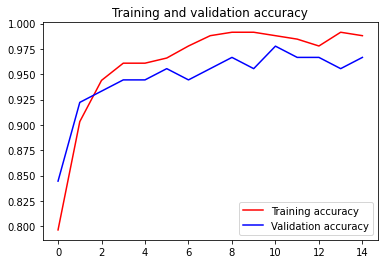

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

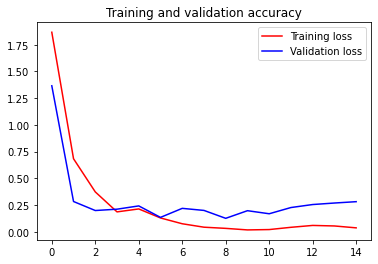

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
def VGG16_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE3, IMG_SIZE3, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model2 = Sequential()
covid_model2.add(VGG16_model())
covid_model2.add(Dropout(0.25))
covid_model2.add(Dense(512, activation='relu'))
covid_model2.add(Dropout(0.25))
covid_model2.add(Dense(64, activation='relu'))
covid_model2.add(Dense(3, activation='sigmoid'))

covid_model2.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_7 (Functional)    (None, 25088)             14714688  
_________________________________________________________________
dropout_6 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 27,593,283
Trainable params: 12,878,595
N

In [ ]:
train_generator2 = train_datagen.flow_from_directory(train_dir,batch_size=BATCH_SIZE,class_mode='categorical',target_size=(IMG_SIZE3,IMG_SIZE3))

validation_generator2 = test_datagen.flow_from_directory(test_dir,batch_size=BATCH_SIZE,class_mode='categorical',target_size=(IMG_SIZE3,IMG_SIZE3))

Found 589 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam

covid_model2.compile(loss='categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy'])

history2 = covid_model2.fit(train_generator2,validation_data=validation_generator2,epochs=EPOCHS,callbacks=[callback])

Epoch 1/20
99/99 [==============================] - 19s 195ms/step - loss: 0.5587 - accuracy: 0.7317 - val_loss: 0.3039 - val_accuracy: 0.8667
Epoch 2/20
99/99 [==============================] - 19s 195ms/step - loss: 0.2105 - accuracy: 0.9304 - val_loss: 0.2013 - val_accuracy: 0.9333
Epoch 3/20
99/99 [==============================] - 19s 196ms/step - loss: 0.1637 - accuracy: 0.9474 - val_loss: 0.1815 - val_accuracy: 0.9444
Epoch 4/20
99/99 [==============================] - 19s 195ms/step - loss: 0.1305 - accuracy: 0.9559 - val_loss: 0.1315 - val_accuracy: 0.9333
Epoch 5/20
99/99 [==============================] - 19s 197ms/step - loss: 0.1007 - accuracy: 0.9660 - val_loss: 0.1053 - val_accuracy: 0.9556
Epoch 6/20
99/99 [==============================] - 19s 194ms/step - loss: 0.0857 - accuracy: 0.9694 - val_loss: 0.1746 - val_accuracy: 0.9222
Epoch 7/20
99/99 [==============================] - 19s 196ms/step - loss: 0.0983 - accuracy: 0.9745 - val_loss: 0.1433 - val_accuracy: 0.9222

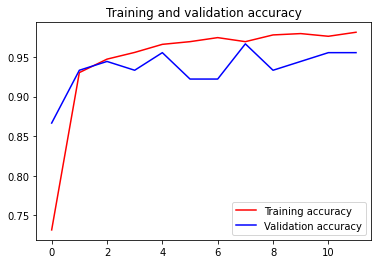

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

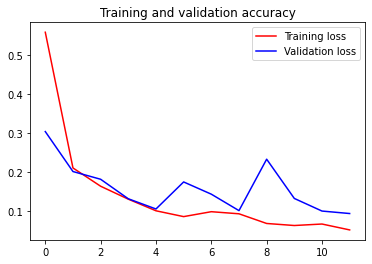

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()